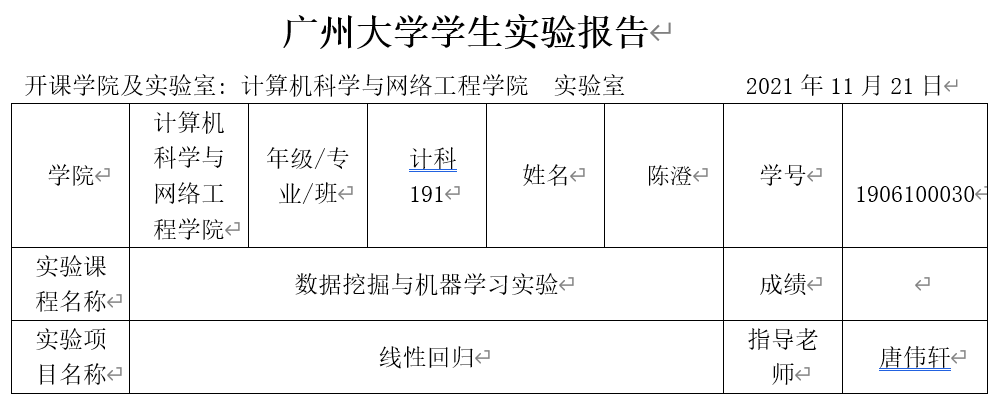

---

# 实验一  线性回归
## 一、 实验目的
本实验课程是计算机、人工智能、软件工程等专业学生的一门专业课程，通过实验，帮助学生更好地掌握数据挖掘与机器学习相关概念、技术、原理、应用等；通过实验提高学生编写实验报告、总结实验结果的能力；使学生对机器学习模型、算法等有比较深入的认识。要掌握的知识点如下：
1.	掌握机器学习中涉及的相关概念、模型、算法；
2.	熟悉机器学习模型训练、验证、测试的流程；
3.	熟悉常用的数据预处理方法；
4.	掌握线性回归优化问题的表示、求解及编程。

## 二、基本要求

1.	实验前，复习《数据挖掘与机器学习》课程中的有关内容。
2.	准备好实验数据，编程完成实验内容，收集实验结果。
3.	独立完成实验报告。


## 三、实验软件
推荐使用Python编程语言（允许使用numpy库，需实现详细实验步骤，不允许直接调用scikit-learn中关于回归、分类等高层API）。


## 四、实验内容：
基于California Housing Prices数据集，完成关于房价预测的线性回归模型训练、测试与评估。
1. 准备数据集并认识数据

    下载California Housing Prices数据集https://www.kaggle.com/camnugent/california-housing-prices
    
    了解数据集各个维度特征及预测值的含义

2. 探索数据并预处理数据
	
    观察数据集各个维度特征及预测值的数值类型与分布
	
    预处理各维度特征（如将类别型维度ocean_proximity转换为one-hot形式的数值数据），参考：https://blog.csdn.net/SanyHo/article/details/105304292
	
    划分70%的样本作为训练数据集，30%的样本作为测试数据集

3. 求解模型参数
	
    编程实现线性回归模型的闭合形式参数求解
	
    编程实现线性回归模型的梯度下降参数优化

4. 测试和评估模型
 	
    在测试数据集上计算所训练模型的R2指标

## 五、学生实验报告要求
**实验报告需要包含以下几个部分**

（1）简要介绍线性回归闭合形式参数求解的原理

（2）简要介绍线性回归梯度下降参数求解的原理

（3）程序清单（包含详细求解步骤）

（4）展示实验结果，比较两种求解方式的优劣

（5）讨论实验结果，分析各个特征与目标预测值的正负相关性

---

- R2评价指标
$$
R^2=1-\frac
{\sum_i(\widehat{y_i}-y_i)^2}
{\sum_u(\overline{y_i}-y)^2}
$$

### 线性回归闭合形式参数求解原理

通过最小化代价函数来求解模型的参数向量 $\theta$ 这个数学问题是有闭式解或解析解的，即可以通过数学公式求解

$$
\theta = (X^T X)^{-1}X^Ty
$$

### 线性回归梯度下降参数求解的原理

从某一个 θ 的初始值开始，然后通过训练集逐渐重复更新，当遇到训练样本的预测值与 y(i) 的真实值非常接近的情况下，就会发现基本没必要再对参数进行修改了；与此相反的情况是，如果我们的预测值 hθ(x(i)) 与 y(i) 的真实值有很大的误差（比如距离特别远），那就需要对参数进行更大地调整。


$\theta_j := \theta_j + \alpha \sum_{i=1}^{m}(y^{(i)}-h_\theta(x^{(i)}))x_j^{(i)} \quad(for\ every\ j)$

### 正规方程求解与梯度下降求解的比较

1. 梯度下降需要选择学习率$\alpha$而正规方程不需要
2. 梯度下降需要迭代多次，而正规方程只需要一次运算
3. 当特质数量n大的适合也能很好的适用，而正规方程一旦特征数量大是运算会比较艰难，因为$(X^TX)^{-1}$的计算
4. 梯度下降可以用在其他模型之上，而正规方程只适用于线性模型，无法适用于逻辑回归等等。。。


In [2]:
import numpy as np
import pandas as pd

In [3]:
# 实现线性回归模型
class LinearRegression(object):
    def __init__(self):
        self.w = 0  # 斜率
        self.b = 0  # 截距
        self.sqrLoss = 0  # 最小均方误差
        self.trainSet = 0  # 训练集特征
        self.label = 0  # 训练集标签
        self.learning_rate = None  # 学习率
        self.n_iters = None  # 实际迭代次数
        self.lossList = []  # 梯度下降每轮迭代的误差列表

    def train(self, X, y, method, learning_rate=0.1, n_iters=1000):
        if X.ndim < 2:
            raise ValueError("X must be 2D array-like!")
        self.trainSet = X
        self.label = y
        if method.lower() == "formula":
            self.__train_formula()
        elif method.lower() == "matrix":
            self.__train_matrix()
        elif method.lower() == "gradient":
            self.__train_gradient(learning_rate, n_iters)
        else:
            raise ValueError("method value not found!")
        return

    # 公式求解法(仅适用于一元线性回归)
    def __train_formula(self):
        # w = \frac{\sum^{m}_{i=1}y_i(x_i-(\overline{x}))}
        # {\frac{1}{m}\sum^m_{i=1}(y_i-wx_i)}
        #
        # b = \frac{1}{m}\sum^m_{i=1}(x_i)^2-n{\overline{x}}^2

        n_samples, n_features = self.trainSet.shape
        # 将X扁平化处理 二维降为一维
        X = self.trainSet.flatten()
        # y是一维的 直接赋值
        y = self.label
        Xmean = np.mean(X)
        ymean = np.mean(y)
        # 求w
        self.w = (np.dot(X, y) - n_samples * Xmean * ymean) / (np.power(X, 2).sum() - n_samples * Xmean ** 2)
        # 求b
        self.b = ymean - self.w * Xmean
        # 求误差
        self.sqrLoss = np.power((y - np.dot(X, self.w) - self.b), 2).sum()
        return

    # 矩阵求解法
    def __train_matrix(self):
        n_samples, n_features = self.trainSet.shape
        X = self.trainSet
        y = self.label
        # 合并w和b，在X尾部添加一列全是1的特征
        X2 = np.hstack((X, np.ones((n_samples, 1))))
        # 求w和b
        EX = np.linalg.inv(np.dot(X2.T, X2))
        what = np.dot(np.dot(EX, X2.T), y)
        self.w = what[:-1]
        self.b = what[-1]
        self.sqrLoss = np.power((y - np.dot(X2, what).flatten()), 2).sum()
        return

    # 梯度下降法
    def __train_gradient(self, learning_rate, n_iters, minloss=1.0e-6):
        n_samples, n_features = self.trainSet.shape
        X = self.trainSet
        y = self.label
        # 初始化迭代次数为0，初始化w0，b0为1，初始化误差平方和以及迭代误差之差
        n = 0
        w = np.ones(n_features)
        b = 1
        sqrLoss0 = np.power((y - np.dot(X, w).flatten() - b), 2).sum()
        self.lossList.append(sqrLoss0)
        deltaLoss = np.inf
        while (n < n_iters) and (sqrLoss0 > minloss) and (abs(deltaLoss) > minloss):
            # 求w和b的梯度
            ypredict = np.dot(X, w) + b
            gradient_w = -1. * np.dot((y - ypredict), X) / n_samples
            gradient_b = -1. * sum(y - ypredict) / n_samples
            # 更新w和b
            w = w - learning_rate * gradient_w
            b = b - learning_rate * gradient_b
            # 求更新后的误差和更新前后的误差之差
            sqrLoss1 = np.power((y - np.dot(X, w).flatten() - b), 2).sum()
            deltaLoss = sqrLoss0 - sqrLoss1
            sqrLoss0 = sqrLoss1
            self.lossList.append(sqrLoss0)
            n += 1
        self.w = w
        self.b = b
        self.sqrLoss = sqrLoss0
        self.learning_rate = learning_rate
        self.n_iters = n + 1
        return
    
    # 测试数据集上计算所训练模型的R2指标
    def R2_Score(self, X_test, y_test):
        # 分子部分表示真实值与预测值的平方差之和
        u = (((np.dot(X_test, self.w) + self.b).reshape(y_test.shape) - y_test) ** 2).sum()
        # 分母部分表示真实值与均值的平方差之和
        v = ((y_test - y_test.mean()) ** 2).sum()
        return 1 - (u / v)
    
    # 预测
    def pre(self, X):
        return np.dot(X, self.w) +  self.b
    

In [4]:
# 一元线性回归测试
X = np.array([1,2,3,4,5]).reshape(-1,1)
y = np.array([3,5,7,9,11])
lr = LinearRegression()
lr.train(X, y, 'formula')
print("公式法求解：w: {0} b: {1}".format(lr.w, lr.b))
# lr.pre(np.array([1]).reshape(-1,1))

lr.train(X, y, 'matrix')
print("矩阵求解：w: {0} b: {1}".format(lr.w, lr.b))

lr.train(X, y, 'gradient', n_iters=1000, learning_rate=0.05)
print("梯度下降求解：w: {0} b: {1}".format(lr.w, lr.b))

公式法求解：w: 2.0 b: 1.0
矩阵求解：w: [2.] b: 1.0000000000000033
梯度下降求解：w: [1.99778663] b: 1.0079909799287847


In [5]:
# 测试housing数据集
data = pd.read_csv("housing.csv" )
data = data.sample(frac=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20640 entries, 14462 to 10870
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [7]:
# 删除存在缺失值的行
data.dropna(inplace=True)
data.head(10)
# 删除缺失行只少了一两百条数据，无伤大雅

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12319,-116.71,33.94,12.0,549.0,109.0,209.0,90.0,3.0208,66300.0,INLAND
2475,-119.97,36.44,18.0,1128.0,237.0,772.0,220.0,2.1771,39200.0,INLAND
2346,-119.69,36.81,15.0,2892.0,496.0,1634.0,501.0,4.4934,88000.0,INLAND
11645,-118.04,33.81,27.0,2990.0,515.0,1849.0,497.0,5.6846,216100.0,<1H OCEAN
14493,-117.19,32.86,19.0,3716.0,563.0,1788.0,587.0,5.2113,267400.0,NEAR OCEAN
13713,-117.17,34.12,2.0,3867.0,573.0,1275.0,433.0,5.4138,164400.0,INLAND
19493,-121.00,37.67,27.0,2278.0,479.0,995.0,449.0,2.5148,110200.0,INLAND
12498,-121.46,38.56,52.0,1750.0,372.0,764.0,369.0,2.9191,111800.0,INLAND
3076,-119.23,35.74,16.0,2275.0,659.0,1914.0,614.0,2.0330,68400.0,INLAND
2064,-119.80,36.68,31.0,2214.0,432.0,1326.0,416.0,2.1691,66700.0,INLAND


In [8]:
# 切分X，y
y = data['median_house_value']
x = data.drop('median_house_value', axis=1)
x.shape, y.shape

((20433, 9), (20433,))

In [9]:
# 把最后一列文字类型转为数字
strs = x['ocean_proximity'].value_counts()
value_map = dict((v, i) for i, v in enumerate(strs.index))
# {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}
x = x.replace({'ocean_proximity':value_map})
x.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12319,-116.71,33.94,12.0,549.0,109.0,209.0,90.0,3.0208,1
2475,-119.97,36.44,18.0,1128.0,237.0,772.0,220.0,2.1771,1
2346,-119.69,36.81,15.0,2892.0,496.0,1634.0,501.0,4.4934,1
11645,-118.04,33.81,27.0,2990.0,515.0,1849.0,497.0,5.6846,0
14493,-117.19,32.86,19.0,3716.0,563.0,1788.0,587.0,5.2113,2
13713,-117.17,34.12,2.0,3867.0,573.0,1275.0,433.0,5.4138,1
19493,-121.00,37.67,27.0,2278.0,479.0,995.0,449.0,2.5148,1
12498,-121.46,38.56,52.0,1750.0,372.0,764.0,369.0,2.9191,1
3076,-119.23,35.74,16.0,2275.0,659.0,1914.0,614.0,2.0330,1
2064,-119.80,36.68,31.0,2214.0,432.0,1326.0,416.0,2.1691,1


In [10]:
# 将特征x标准化，方便收敛
x = (x - x.mean(axis=0)) / x.std(axis=0)

In [11]:
# 划分训练集测试集 7 - 3
trainNum = int(x.shape[0] * 0.7)
x_train = np.array(x[-trainNum:])
x_test = np.array(x[:-trainNum])
y_train = np.array(y[-trainNum:])
y_test = np.array(y[:-trainNum])
(x_train.shape, x_test.shape), (y_train.shape, y_test.shape)

(((14303, 9), (6130, 9)), ((14303,), (6130,)))

In [12]:
lr.train(x_train, y_train, "matrix")
print("矩阵求解：w: {0} b: {1}".format(lr.w, lr.b))
score = lr.R2_Score(x_test, y_test)
print("R2: {0}".format(score))

矩阵求解：w: [-85367.22607692 -90142.93275644  14038.65639225 -17207.96187937
  49080.96009939 -50066.06260411  22337.10768409  76251.09230245
  -1684.93729388] b: 206311.57809515327
R2: 0.6199234190819212


In [13]:
lr.train(x_train, y_train, "Gradient", n_iters=1000, learning_rate=0.05)
print("梯度下降法求解：w: {0} b: {1}".format(lr.w, lr.b))
score = lr.R2_Score(x_test, y_test)
print("R2: {0}".format(score))

梯度下降法求解：w: [-81049.00479435 -86047.87897316  14366.2982927  -16811.67501366
  40387.56727049 -51239.41242101  31797.81383627  76447.24316014
  -1440.68848728] b: 206302.94298971145
R2: 0.6192400882563365


大概是因为数据集太脏了，没有做过多的数据预处理，训练效果并不明显